In [36]:
import json
import pandas as pd

def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
credits = load_tmdb_credits('../tmdb_5000_credits.csv')
movies = load_tmdb_movies('../tmdb_5000_movies.csv')

In [35]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [31]:
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [25]:
df_initial.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe


In [26]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

In [27]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [28]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

(-0.5, 999.5, 299.5, -0.5)

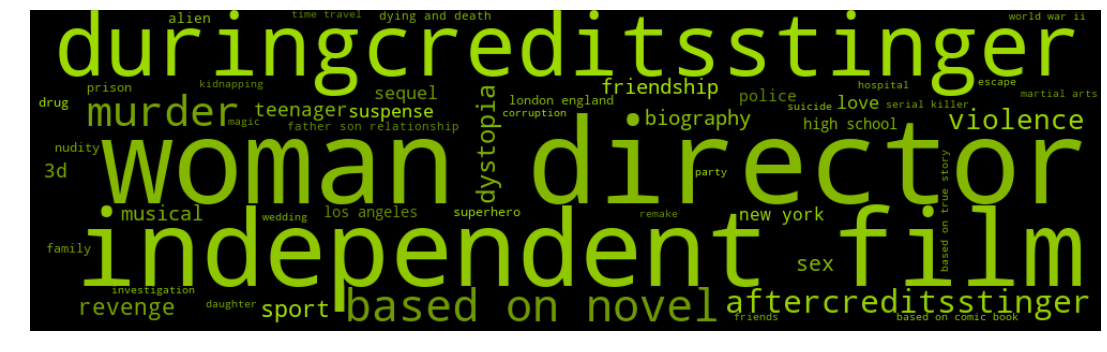

In [30]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________

words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')